## 11.11. 学习率调度器

### 11.11.1. 一个简单的问题

In [16]:
%matplotlib inline
import math
import mindspore
from mindspore import nn
from d2l import mindspore as d2l
from mindspore import value_and_grad

def net_fn():
    model = nn.SequentialCell(
        nn.Conv2d(1, 6, kernel_size=5, padding=2, pad_mode='pad', weight_init='HeUniform'), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5, pad_mode='valid', weight_init='HeUniform'), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Dense(16 * 5 * 5, 120, weight_init='HeUniform'), nn.ReLU(),
        nn.Dense(120, 84, weight_init='HeUniform'), nn.ReLU(),
        nn.Dense(84, 10, weight_init='HeUniform'))

    return model

loss = nn.CrossEntropyLoss()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
steps_per_epoch = train_iter.get_dataset_size()

# 代码几乎与d2l.train_ch6定义在卷积神经网络一章LeNet一节中的相同
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device=None):
    # 定义前向传播函数
    def forward_fn(x, y):
        y_hat = net(x)
        l = loss(y_hat, y)
        return l, y_hat
    
    # Get gradient function
    grad_fn = value_and_grad(forward_fn, None, weights=net.trainable_params(), has_aux=True)
    
    # 定义模型单步训练
    def train_step(X, y):
        (l, y_hat), grads = grad_fn(X, y)
        trainer(grads) # optim
        return l, y_hat
    
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0, 2.3],
                            legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            l, y_hat = train_step(X, y)
            metric.add(l.asnumpy() * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
     
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / train_iter.get_dataset_size(),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

train loss 0.098, train acc 0.963, test acc 0.885


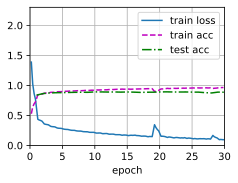

In [18]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = nn.SGD(net.trainable_params(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer)

### 11.11.2. 学习率调度器

In [19]:
# 改写learning_rate参数的值
mindspore.ops.assign(trainer.learning_rate, d2l.tensor(0.1))
print(f'learning rate is now {trainer.learning_rate.data.asnumpy():.2f}')

learning rate is now 0.10


In [4]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

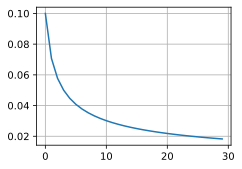

In [5]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(d2l.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

mindspore学习率

train loss 0.245, train acc 0.910, test acc 0.887


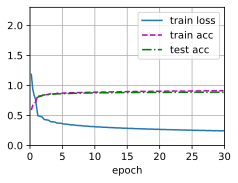

In [6]:
net = net_fn()
lr_list = d2l.tensor([scheduler(t) for t in range(num_epochs) for i in range(steps_per_epoch)])
trainer = nn.SGD(net.trainable_params(), lr_list)
train(net, train_iter, test_iter, num_epochs, loss, trainer)

#### 11.11.3.1. 单因子调度器

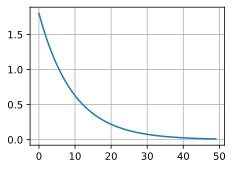

In [7]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(d2l.arange(50), [scheduler(t) for t in range(50)])

#### 11.11.3.2. 多因子调度器

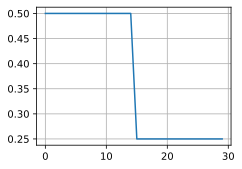

In [8]:
class MultiFactorScheduler:
    def __init__(self, step, factor, base_lr):
        self.step = step
        self.factor = factor
        self.base_lr = base_lr

    def __call__(self, epoch):
        if epoch in self.step:
            self.base_lr = self.base_lr * self.factor
            return self.base_lr
        else:
            return self.base_lr

scheduler = MultiFactorScheduler(step=[15, 30], factor=0.5, base_lr=0.5)
d2l.plot(d2l.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.273, train acc 0.896, test acc 0.867


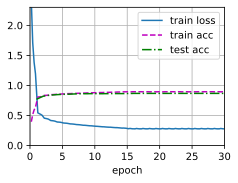

In [9]:
net = net_fn()
lr_list = d2l.tensor([scheduler(t) for t in range(num_epochs) for i in range(steps_per_epoch)])
trainer = nn.SGD(net.trainable_params(), lr_list)
train(net, train_iter, test_iter, num_epochs, loss, trainer)

#### 11.11.3.3. 余弦调度器

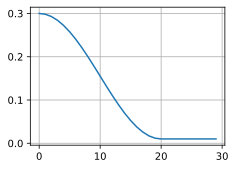

In [11]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(d2l.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.143, train acc 0.948, test acc 0.901


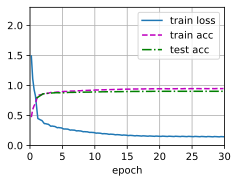

In [12]:
net = net_fn()
lr_list = d2l.tensor([scheduler(t) for t in range(num_epochs) for i in range(steps_per_epoch)])
trainer = nn.SGD(net.trainable_params(), lr_list)
train(net, train_iter, test_iter, num_epochs, loss, trainer)

#### 11.11.3.4. 预热

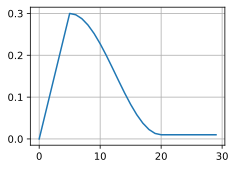

In [13]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(d2l.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.171, train acc 0.938, test acc 0.898


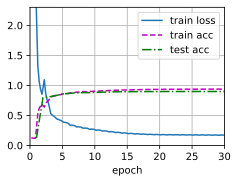

In [14]:
net = net_fn()
lr_list = d2l.tensor([scheduler(t) for t in range(num_epochs) for i in range(steps_per_epoch)])
trainer = nn.SGD(net.trainable_params(), lr_list)
train(net, train_iter, test_iter, num_epochs, loss, trainer)